# Fitbit Data Exploration: Making a prediction for the two weeks of missing data

By: Norrick McGee and Eric Escalante  
January 19, 2019  

In this Jupyter Notebook, we will use the Time Series Methology and fitbit data collected from 04/26/2018 to 12/06/2018 to predict two weeks worth of missing data; we will add our pridicted data in a separate csv file.

## Imports
**Import the necessary packages and their use cases for this project:**
> **pandas:** data frames and data manipulation  
> **numpy:** summary statistics  
> **matplotlib:** used for visualizations  
> **seasborn:** fancy visualizations  
> **datetime:** turn the dates into datetime objects / get day of week  
> **warning:** used to ignore python warnings  
> **statsmodels:** library of different statistical tests we will be performing thoughout the project

In [115]:
from prepare import prepare_fitbit

import numpy as np
import pandas as pd

import os
from datetime import datetime
import itertools
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet

## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals  
> Goals for the Project are:  
1. We will predict using different Time Series Methodologies the missing two weeks of Fitbit data
2. We will show the reasoning behind our preditions with visualizations and statistical findings
3. Finally we will create a viewable csv file with those pridictions so that you could see the endire dataset

### Deliverables

> **Summarization of the data:**
> The USB thumb drive is not a Rubber Duck USB drive so our trust is still intact with the employee barged into the room. The data on the USB drive was full of FitBit data shoved into 8 CSV files. The files contained months worth of autotracked in formation by FitBit and manually tracked in formation by the Employee. The last 22 days are missing from the AutoTracked information and our job is to predict that information. As we go through the data we will want to add more columns to help us predict the missing information such as months, weeks, and day. These new columns will help us see the employees trends month over month, week over week, and day over day. In the end we will create a new CSV to add to the USB that will have the predicted information for the employee.

### Data Dictionary & Domain Knowledge

We have sixteen columns in our dataset. Let us understand what each one is. We will be adding more throughout the project.

AutoTracked information by FitBit:
>**activity_calories:** amount of calories burned from activity throughout the day  
> **distance:** distance traveled   
> **floors:** floors climbed   
> **mins_active_high:** minutes of high activity in the day   
> **mins_active_light:** minutes of light activity in the day  
> **mins_active_med:** minutes of moderate activity in the day  
> **mins_sedentary:** minutes the fit bit assums you are sitting down  
> **steps:** total amount of steps taken in a day  
> **total_calories:** total calories burned throughout the day  

Manually Tracked information by Employee:  
> **calories:** amount of calories consumed throughout the day  
> **carbs:** amount of carbs consumed throughout the day  
> **fat:** amount of fat consumed throughout the day  
> **fiber:** amount of fiber comsumed throughout the day  
> **protien:** amount of protein consumed throughout the day  
> **sodium:** amount of sodium consumed throughout the day  
> **water:** metric desplays tracked water intake or set a consumption 

### Hypotheses

> 1. The USB thumb drive contains all the FitBit tracking information; however the manually entered information from the daily consumption will not be filled out consistantly.
> 2. The emoloyee will have a slow start in all FitBit tracking fields, but as he/she continues to see progress they will get better as the months go on.
> 3. We will see the minutes sitting down gradually decrease over time and see their moderate to high activity increase over time.

### Thoughts & Questions

> Thoughts:  
1. We should only use our test data once
2. Make sure we are resampling the data if we wanted to to differents training models within our original train data
3. Distance has more data: maybe we use distance to equate the amount of steps
>>1 miles to steps = 2112 steps  
2 miles to steps = 4224 steps  
3 miles to steps = 6336 steps  
4 miles to steps = 8448 steps  
5 miles to steps = 10560 steps  

> Questions: 
1. Where are we going to split our times?
2. What two weeks are we predicting?
3. What is the distance formula?

## Prepare the Environment

## Preparation <a name="preparation"></a>

In [116]:
df = prepare_fitbit()

In [117]:
def add_date_parts(df):
    '''
    Function to add columns based on date: month, day of month, day of week
    '''
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.day_name()
    
    return df

def nulls_by_col(df):
    '''
    Funciton used to find missing information in each column
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing/rows
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'pct_rows_missing': pct_missing})
    
    return cols_missing

def nulls_by_row(df):
    '''
    Function used to find missing information in each row
    '''
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    rows_missing = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing})\
                     .reset_index().groupby(['num_cols_missing','pct_cols_missing']).count()\
                     .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    
    return rows_missing

def df_summary(df):
    '''
    Funciton summarizes our created data frame with information on: shape, type & null info, desribe function from pandas library, null values by column, null values by row, and value counts
    '''
    print('--- Shape: {}'.format(df.shape))
    print('--- Info')
    df.info()
    print('--- Descriptions')
    print(df.describe(include='all'))
    print('--- Nulls By Column')
    print(nulls_by_col(df))
    print('--- Nulls By Row')
    print(nulls_by_row(df))

In [118]:
df = add_date_parts(df)

In [119]:
df_summary(df)

--- Shape: (247, 19)
--- Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2018-04-26 to 2018-12-28
Data columns (total 19 columns):
activity_calories    225 non-null float64
distance             225 non-null float64
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       225 non-null float64
steps                225 non-null float64
total_calories       225 non-null float64
calories             247 non-null int64
carbs                247 non-null object
fat                  247 non-null object
fiber                247 non-null object
protien              247 non-null object
sodium               247 non-null object
water                247 non-null object
month                247 non-null int64
day                  247 non-null int64
weekday              247 non-null object
dtypes: float64(9), int64(3), object(7)
memory usage: 38.6+ K

**Focus:**
> activity_calories  
> steps  
> total_calories  

### Handle Missing Values


>- We do want to look where are current numbers land to see how we want to structure our null values
>- Option could be just to add a zero there; reasoning could because the person forgot to log his info
>- Could use the average because if these guys are so busy that they do not have time for side conversations they may just eat/do the same thing each day  
>- There are non-type or int + str types that we need to work on what to do in this case

In [120]:
for col in df.select_dtypes('number'):
    print(f'\n- {col} -')
    print(df[col].value_counts(bins=4, sort=False))


- activity_calories -
(-3.597, 899.0]      41
(899.0, 1798.0]     113
(1798.0, 2697.0]     60
(2697.0, 3596.0]     11
Name: activity_calories, dtype: int64

- distance -
(-0.013000000000000001, 3.0]    83
(3.0, 6.0]                      88
(6.0, 9.0]                      48
(9.0, 12.0]                      6
Name: distance, dtype: int64

- floors -
(-0.196, 48.75]    216
(48.75, 97.5]        2
(97.5, 146.25]       4
(146.25, 195.0]      3
Name: floors, dtype: int64

- mins_active_high -
(-0.155, 38.5]    142
(38.5, 77.0]       43
(77.0, 115.5]      36
(115.5, 154.0]      4
Name: mins_active_high, dtype: int64

- mins_active_light -
(-0.35, 87.25]      24
(87.25, 174.5]      53
(174.5, 261.75]    121
(261.75, 349.0]     27
Name: mins_active_light, dtype: int64

- mins_active_med -
(-0.079, 19.5]    161
(19.5, 39.0]       45
(39.0, 58.5]       15
(58.5, 78.0]        4
Name: mins_active_med, dtype: int64

- mins_sedentary -
(26.587, 381.0]       1
(381.0, 734.0]      102
(734.0, 1087.0] 

**_Thoughts:_**
> We are going to try and use Facebooks Prophet to generate quick time series data to fill missing values

### Handle Duplicates

**_TODO:_**
> Do we have duplicated data??

### Handle Outliers

**_TODO:_**
> Personally do not want to remove outliers here; however we should be finding the missing values

### Re-Check Missing Values & Summary

In [121]:
df_summary(df)

--- Shape: (247, 19)
--- Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2018-04-26 to 2018-12-28
Data columns (total 19 columns):
activity_calories    225 non-null float64
distance             225 non-null float64
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       225 non-null float64
steps                225 non-null float64
total_calories       225 non-null float64
calories             247 non-null int64
carbs                247 non-null object
fat                  247 non-null object
fiber                247 non-null object
protien              247 non-null object
sodium               247 non-null object
water                247 non-null object
month                247 non-null int64
day                  247 non-null int64
weekday              247 non-null object
dtypes: float64(9), int64(3), object(7)
memory usage: 38.6+ K

## Exploration  <a name="exploration"></a>

In [122]:
def createheatmap(df):
    '''
    Function we will use to create heatmaps with pretty specific parameters that keep these heatmaps uniform
    '''
    sns.set(style = "white")
    corrd = df.corr()
    mask = np.zeros_like(corrd, dtype=np.bool)    ### returns an array of zerros for NA's to fill each column; ensures each column is the same shape
    mask[np.triu_indices_from(mask)] = True       ### returns the indices for the upper-triangle of an (n, m) array.
    f, ax = plt.subplots(figsize=(15, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corrd, mask=mask, cmap=cmap, square=True, 
                xticklabels=True, yticklabels=True, 
                linewidths=.5, ax=ax)

def bin_feature(df, col, newcol, bin_cuts=[]):
    '''
    Function we will use to bin different columns during our exploration -> returns the dataframe with the column binned 
    '''
    labs = list(range(len(bin_cuts)))[1:]
    df[newcol] = pd.cut(df[col], bin_cuts, labels=labs, include_lowest=False)
    
    return df

def summary_stat(df, col_name):
    '''
    Function to provide median, min, and max of data in column -> returns a new small dataframe with the info
    '''
    df = pd.DataFrame({'Mean ' : str(round(np.mean(df[col_name]),2)),
         'Median' : str(np.median(df[col_name])),
         'Min' : str(np.min(df[col_name])),
         'Max' : str(np.max(df[col_name]))}, index=[0])
    
    return df

**_Thoughts:_**
> We want to see how each month looks stacked up together using the distance metric  
> We want to get a total amount so that we can potentially look at the rolling average  
> Instead of the distance we really do want to use **step count**

**Let's create a line graph so we can see the trends of the differnt activity levels in mintues**

Text(0.5, 1.0, 'Monthly and Weekly Active Trend for Employee')

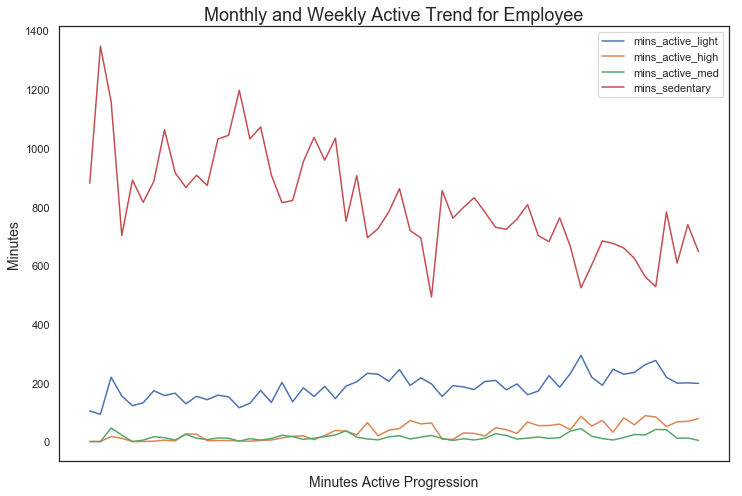

In [149]:
df_activity = df[['mins_active_light', 'mins_active_high', 'mins_active_med','mins_sedentary' ]].groupby([(df.index.month),(df.index.weekday)]).mean()

df_activity[:59].plot(figsize=(12,8))
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Minutes Active Progression', fontsize=14)
plt.title('Monthly and Weekly Active Trend for Employee', fontsize=18)

**_Thoughts:_**
> Here we want to see if the total distance traveled has a trend by month  
> This person had a peak in distance traveled in November; he must have just gotten the FitBit in April  
> We can also add steps once we fill all missing values

**Let's create a line graph so we can see the trends of the amount of steps**

Text(0.5, 1.0, 'Steps Trend for Employee')

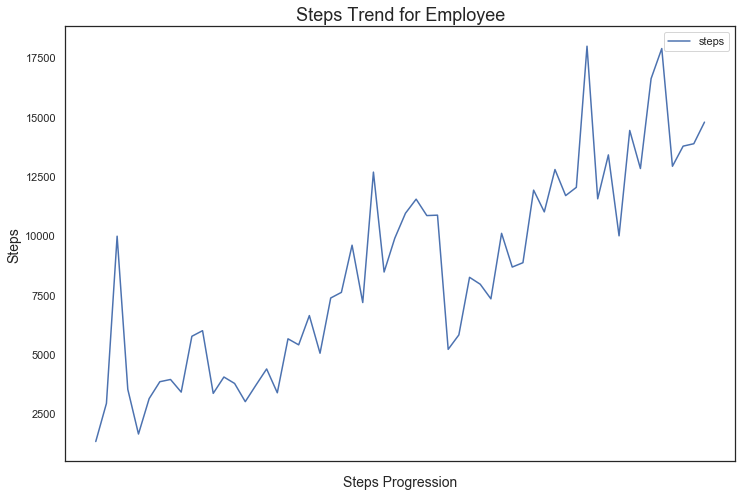

In [126]:
df_distance = df[['steps']].groupby([(df.index.month),(df.index.weekday)]).mean()
df_distance[:59].plot(figsize=(12,8))
plt.ylabel('Steps', fontsize=14)
plt.xlabel('Steps Progression', fontsize=14)
plt.title('Steps Trend for Employee', fontsize=18)


**Let's graph a boxplot so we can see the information in Monthly Steps regarding the shape, variability, and center (or median) of monthly distance**

Text(0.5, 0, 'Month')

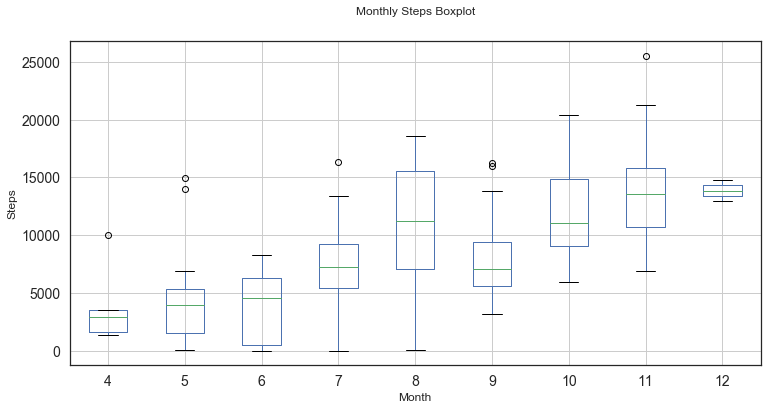

In [127]:
df.boxplot(column = 'steps', by = 'month', figsize=(12,6))

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.title('')
plt.suptitle('Monthly Steps Boxplot')
plt.ylabel('Steps')
plt.xlabel('Month')

**_Thoughts:_**
> Individuals walked distance increased significantly in August  
> His/Her distance remained stable in November and December. However, in May through August, it rose suddenly  
> In August and September, there was a sudden drop in distance  
> The FitBit manually tracks Steps and we can use this information to predict the missing two weeks later on

**Let's graph a boxplot so we can see the information in Active Calories regarding the shape, variability, and center (or median) of monthly distance**

Text(0.5, 0, 'Month')

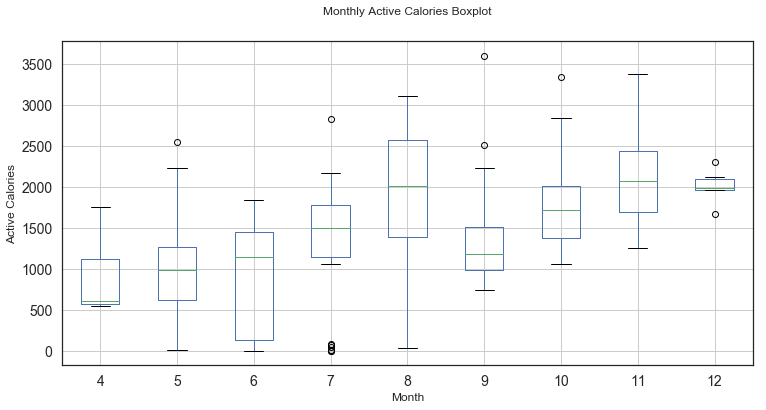

In [128]:
df.boxplot(column = 'activity_calories', by = 'month', figsize=(12,6))

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.title('')
plt.suptitle('Monthly Active Calories Boxplot')
plt.ylabel('Active Calories')
plt.xlabel('Month')

**_Thoughts:_**
> The employee's Active Calorie Boxplot closely resembles the Steps Boxplot  
> We can see if the two features has a strong correlation  
> The FitBit manually tracks Active Calories and we can use this information to predict the missing two weeks later on

> **NORRICK ADD GRAPH HERE**

**Let's looks at all the feature correlations from the FitBit USB we found**

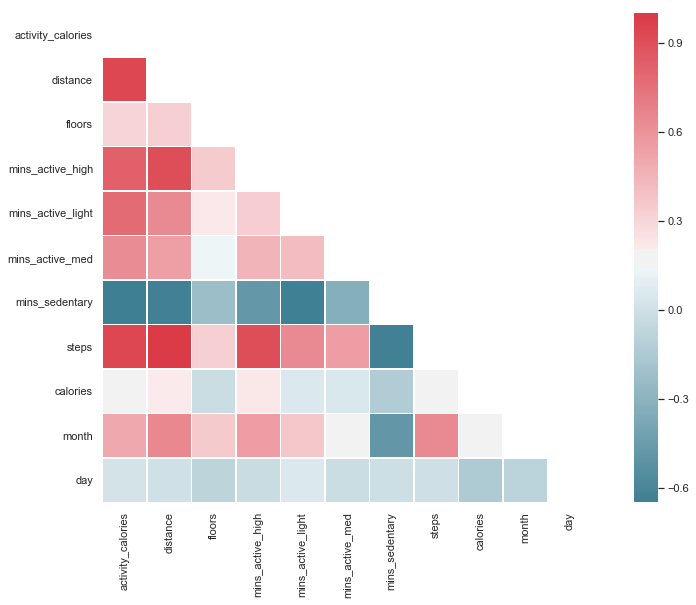

In [129]:
createheatmap(df.drop(columns=['total_calories']))

**_TODO:_**
> Need to figure out different correlations here speak to them...  
> Currently - Total year has too many missing values & year only has the one  
> Which variables are we going to start binning?  
> Which statistical models are we going to start preparing for?

**_TODO: Workday hours, Non workday hours, Weekend hours_**
> Can we create two seperate df for each test  
> New df's will include:
> 1. Days of the week
> 2. Hours from 9 to 5 (as type int)

### Train-Test Split

**_TODO:_**
> 1. Modeling Time Series Using Parametric Methods  
> 2. Prophet

### Visualizations

**_TODO:_**
> **TIME TO SHINE!**

### Statistical Tests

In [130]:
def calculate_r2(Actual_Y, Estimated_Y):
    '''
    Function that calculates R squared
    '''
    return float(1 - sum((Actual_Y-Estimated_Y)**2 ) / sum((Actual_Y-Actual_Y.mean(axis=0))**2))

def calculate_rmse(Actual_Y, Estimated_Y):
    '''
    Function that calculates Root Mean Squared Error
    '''
    return(math.sqrt(sum((Actual_Y-Estimated_Y )**2 ) / Actual_Y.shape[0]))

def evaluate(actual, predictions, output=True):
    '''
    Function calculates the mean squared error and the root mean square error by taking the square root of the mse
    '''
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

### Summarize Conclusions

**_TODO:_**
> Summarize our statistical findings

## Modeling <a name="modeling"></a>

### Prophet Model
**_Objective:_**
> Build a model that will predict data from 12/07 to 12/28  
> We will first be using a Prophet model: https://facebook.github.io/prophet/docs/quick_start.html  
> Prophet only takes data as a dataframe with a ds (datestamp) and y (value we want to forecast) column  
> We will be adding these columns to our original dataframe

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


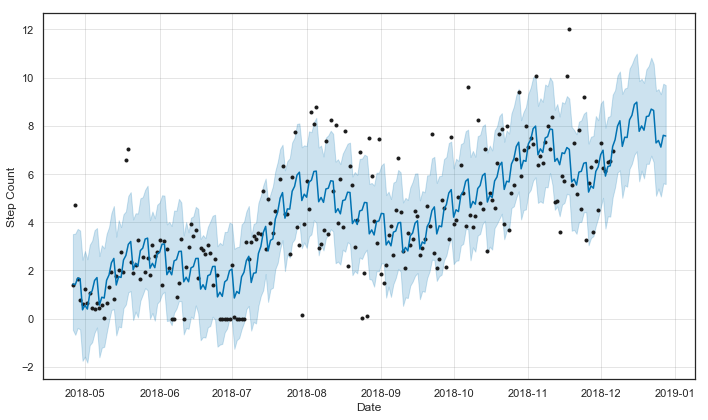

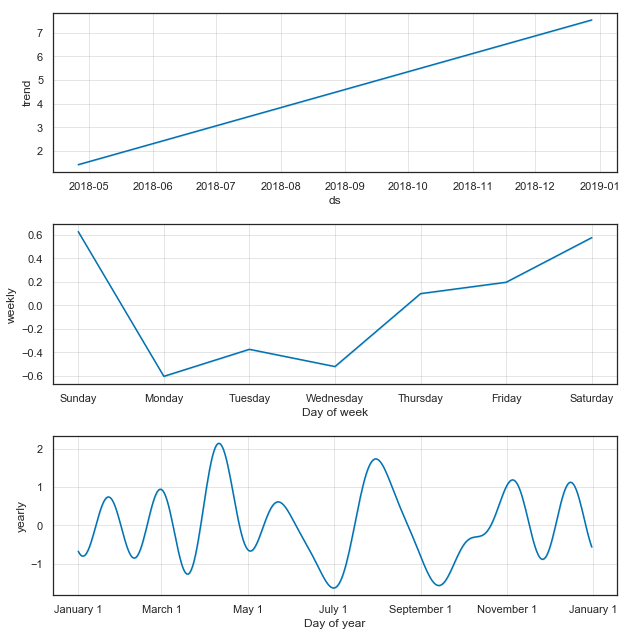

In [131]:
df['ds'] = df.index
df['y'] = df.distance

m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.3)
m.fit(df)

forecast = m.predict(df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)
plt.ylabel('Step Count', fontsize=12)
plt.xlabel('Date', fontsize=12)


fig2 = m.plot_components(forecast)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00




    horizon       mse      rmse       mae       mape  coverage
92   3 days  5.770147  2.402113  2.041369  10.103230  0.476190
63   4 days  5.891572  2.427256  2.073149  10.143929  0.428571
153  4 days  5.850779  2.418838  2.034480  10.138088  0.428571
33   4 days  5.777435  2.403630  2.026944   2.318450  0.428571
183  4 days  5.382053  2.319925  1.933352   2.307621  0.476190




Text(0, 0.5, 'Mean Squared Error')

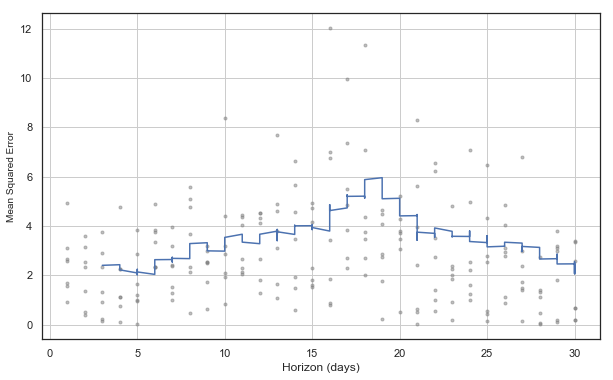

In [132]:
### Evaluation using Prophet’s cross validation (built in function)
from fbprophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(m, horizon='30 days')

df_p = pd.DataFrame(performance_metrics(df_cv))
print('\n')
print(df_p.head(5))
print('\n')

### Evaluation using Prophet’s cross validation plot (built in function)
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.ylabel('Mean Squared Error', fontsize=10)

### Feature Engineering & Selection

In [133]:
def new_features(df):
    '''
    Function used to create new features -> returns the original dataframe with new features added
    '''
    return df

def plot_data_and_predictions(predictions, label):
    '''
    Function plots using matplotlib
    '''
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()

### Add plot_and_eval function from curriculum

### Train & Test Models

**_TODO:_**
> Build some models here:
1. Would like to build a few functions here so that we could do differnt ML methods
2. What is going to be our goal??
3. I think we need to separate the data into different slices (i.e. use Sunday thru Friday to predict Saturday; Monday thru Saturday to predict Sunday... and so on)

### Summarize Conclusions

**_TODO:_**
> Sumarize our training and test builds  
> Create the CSV  
> Find differnt ways to improve  